# Minflux data extraction

Load files to analyse and export the data using MfxData class
Perform an initial data inspection of reference beads, number of tracks etc. 


In [1]:
# Some imports
import sys
import os, glob
from mfxdata import MfxData 
import re
import math


In [2]:
# Set names
# Reading from network drive Zarr is still rather slow. Do not know why. 
# Write/read to a 'local' Harddrive is 10x faster. The whole handling of a file takes 2 min, instead of 10-30 sec

OUTDIR_LOC = 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis/' # Main directory to store zarr files
OUTDIR_REM =  'Z:/siva_minflux/analysis/'  # Main directory to store results 
INDIR  = 'Z:/siva_minflux/data/'       # main directory of msr file

# Multiple washes with different imager strand
indir_mwash = {'Syp_ATG9': INDIR + '/Multiwash/Syp_ATG9/', 
             'ZnT3_Syp': INDIR + '/Multiwash/ZnT3_Syp/'}
outdir_mwash = {'Syp_ATG9': OUTDIR_REM +  '/Multiwash/Syp_ATG9/', 
                'ZnT3_Syp': OUTDIR_REM +  '/Multiwash/ZnT3_Syp/'}
zarrdir_mwash = {'Syp_ATG9': OUTDIR_LOC + '/Multiwash/Syp_ATG9', 
                'ZnT3_Syp': OUTDIR_LOC + '/Multiwash/ZnT3_Syp/'}

# Wash with a single imager strand
indir_swash = {'Syp': INDIR + '/Single wash/Syp/', 
             'ATG9': INDIR + '/Single wash/ATG9/'}
outdir_swash = {'Syp': OUTDIR_REM +  '/Single wash/Syp/', 
                'ATG9': OUTDIR_REM +  '/Single wash/ATG9/'}
zarrdir_swash = {'Syp': OUTDIR_LOC +  '/Single wash/Syp/', 
                'ATG9': OUTDIR_LOC +  '/Single wash/ATG9/'}

# Consitency controls. Wash with a single imager strand but multiple times. 
indir_cwash = {'VGLUT1_VGLUT1': INDIR + '/Multiwash/VGLUT1_VGLUT1/'}
outdir_cwash = {'VGLUT1_VGLUT1': OUTDIR_REM +  '/Multiwash/VGLUT1_VGLUT1/'}
zarrdir_cwash = {'VGLUT1_VGLUT1': OUTDIR_LOC +  '/Multiwash/VGLUT1_VGLUT1/'}




# Create a list of msr files to process
msr_mwash = {}
for key in indir_mwash:
    msr_mwash[key] = glob.glob(indir_mwash[key] + '*.msr')

msr_swash = {}
for key in indir_swash:
    msr_swash[key] = glob.glob(indir_swash[key] + '*.msr')

    
msr_cwash = {}
for key in indir_cwash:
    msr_cwash[key] = glob.glob(indir_cwash[key] + '*.msr')
    

In [14]:
# Realign data funcion
def align_data(msr_files, outdir, zarr_dir, invalid_msr, exclude_beads, time_diff_ref):
    for wash_key in msr_files:
        for file_path in msr_files[wash_key]:
            
            file_name = os.path.basename(file_path)
            if file_name in invalid_msr:
                continue
            mfx = MfxData(file_path, outdir_main=outdir[wash_key], 
                          zarr_dir_main=zarr_dir[wash_key])
            if file_name in time_diff_ref:
                mfx.MAX_TDIFF_REF = time_diff_ref[file_name]
            else:
                mfx.MAX_TDIFF_REF = 10
            mfx.zarr_import()
            mfx.set_valid_ref()
            print('\n'+ mfx.msrfile_path)
            print(mfx.valid_ref_beads)
            if file_name in exclude_beads:
                mfx.valid_ref_beads = [x for x in mfx.valid_ref_beads if x not in exclude_beads[file_name]]
            print(mfx.valid_ref_beads)
            regis = mfx.get_ref_transform()
            mfx.show_ref_transform(translate=regis[mfx.TRANS], rotate=None, save=True, show=True)
            out_data_dict = mfx.align_to_ref()
            mfx.export_numpy(out_data_dict)
            mfx.export_ref_mat() 

def preview_data(msr_files, outdir, zarr_dir, idfile, wash_key, time_diff_ref = 10):
    mfx = MfxData(msr_files[wash_key][idfile], outdir_main=outdir[wash_key], 
                          zarr_dir_main=zarr_dir[wash_key])
    print(mfx.msrfile_path)
    mfx.MAX_TDIFF_REF = time_diff_ref
    mfx.zarr_import()
    print(mfx.zarrdir)
    mfx.set_valid_ref()
    print(mfx.valid_ref_beads)
    if len(mfx.valid_ref_beads)==0
        printt('No valid reference beads ')
        return
    regis = mfx.get_ref_transform()
    mfx.show_ref_transform(translate=regis[mfx.TRANS], rotate=None, save=False, show=True)


SyntaxError: invalid syntax (643691279.py, line 37)

In [4]:
# Preview data mwash
preview_data(msr_files=msr_mwash, outdir=outdir_mwash, zarr_dir=zarrdir_mwash,  wash_key='Syp_ATG9',
             idfile=1, time_diff_ref=10)

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220510_Syp_ATG9_ROI02.msr
{'220510_Syp_P1': 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis//Multiwash/Syp_ATG9\\220510_Syp_ATG9_ROI02\\220510_Syp_P1', '220510_ATG9_P2': 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis//Multiwash/Syp_ATG9\\220510_Syp_ATG9_ROI02\\220510_ATG9_P2'}
[]


IndexError: list index out of range

In [5]:
# Valid msr files, for instance because lacking of common reference. This can be fixed at a later time point 
invalid_mwash = {'220510_Syp_ATG9_ROI02.msr'}
exclude_beads_mwash = {'220510_Syp_ATG9_ROI03.msr': ['R4'], '220601_Syp_ATG9_ROI03.msr': ['R10'], 
                       '220825_Syp_ATG9_ROI01.msr': ['R13']}
time_diff_mwash = {'220309_ZnT3_Syp_ROI01.msr': 1500, '220309_ZnT3_Syp_ROI03.msr': 1200}
# Syp_ATG9
# 220510_Syp_ATG9_ROI01.msr: 6 beads, good
# 220510_Syp_ATG9_ROI02.msr: No common beads, needs a matching
# 220510_Syp_ATG9_ROI03.msr: Exclude R4
# 220601_Syp_ATG9_ROI01.msr: 3 beads, ok
# 220601_Syp_ATG9_ROI02.msr: 4 beads, good
# 220601_Syp_ATG9_ROI03.msr: 4 beads, ok,  exclude R10
# 220601_Syp_ATG9_ROI04.msr: 4 beads, good
# 220601_Syp_ATG9_ROI05.msr: 4 beads, ok
# 220601_Syp_ATG9_ROI06.msr: 4 beads, good
# 220601_Syp_ATG9_ROI07.msr: 3 beads, ok
# 220614_Syp_ATG9_ROI01.msr: 3 beads, ok
# 220825_Syp_ATG9_ROI01.msr: 5 beads, poor, strange fluctuations. Exclude R13. Failed to align ??. Do not use

# ZnT3_Syp
# 220309_ZnT3_Syp_ROI01.msr: 3 beads, ok
# 220309_ZnT3_Syp_ROI02.msr: 3 beads, ok 
# 220309_ZnT3_Syp_ROI03.msr: 2 beads!!, poor



Z:/siva_minflux/data//Multiwash/Syp_ATG9\220510_Syp_ATG9_ROI01.msr
['R0', 'R1', 'R2', 'R3', 'R4', 'R9']
['R0', 'R1', 'R2', 'R3', 'R4', 'R9']


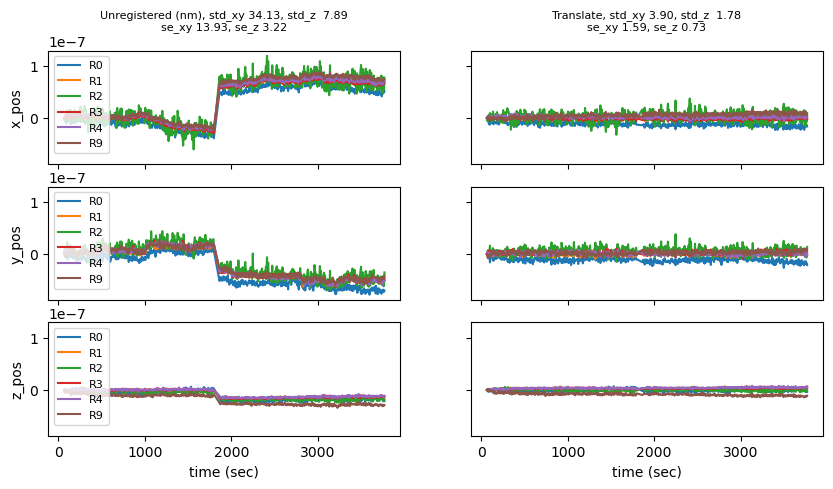

Valid tracks 220510-Syp_P1 615/46945
Localizations in invalid tracks 220510-Syp_P1 3/50968
Valid tracks 220510-ATG9_P2 392/62083
Localizations in invalid tracks 220510-ATG9_P2 6/65016

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220510_Syp_ATG9_ROI03.msr
['R0', 'R1', 'R2', 'R4']
['R0', 'R1', 'R2']


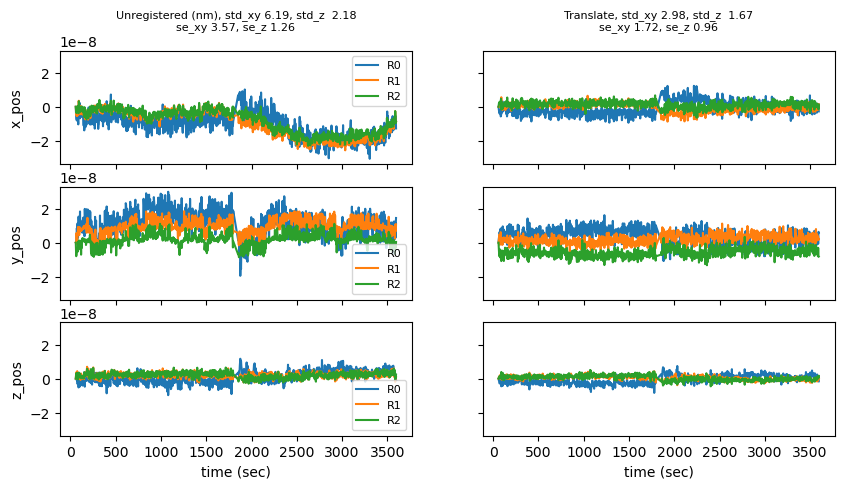

Valid tracks 220510_Syp_P1 1297/45515
Localizations in invalid tracks 220510_Syp_P1 8/55526
Valid tracks 220510_ATG9_P2 951/51343
Localizations in invalid tracks 220510_ATG9_P2 3/58610

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220601_Syp_ATG9_ROI01.msr
['R2', 'R3', 'R8']
['R2', 'R3', 'R8']


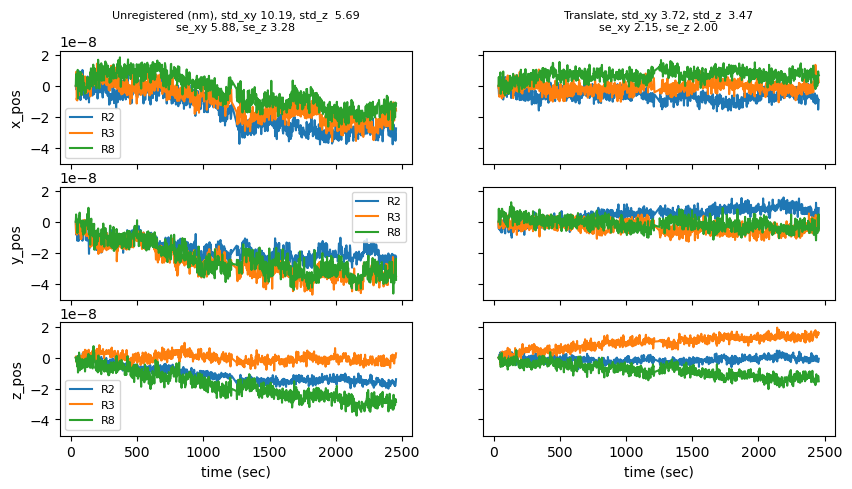

Valid tracks 220601_Syp_P1 96/35243
Localizations in invalid tracks 220601_Syp_P1 25/35682
Valid tracks 220601_ATG9_P2 36/36554
Localizations in invalid tracks 220601_ATG9_P2 12/36706

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220601_Syp_ATG9_ROI02.msr
['R10', 'R2', 'R5', 'R6']
['R10', 'R2', 'R5', 'R6']


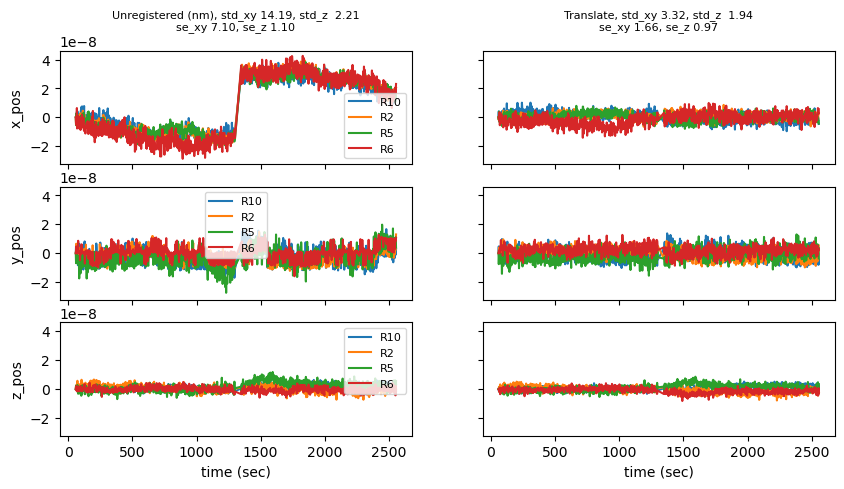

Valid tracks 220601_Syp_P1 60/30413
Localizations in invalid tracks 220601_Syp_P1 37/30621
Valid tracks 220601_ATG9_P2 13/30688
Localizations in invalid tracks 220601_ATG9_P2 6/30735

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220601_Syp_ATG9_ROI03.msr
['R10', 'R2', 'R5', 'R6']
['R2', 'R5', 'R6']


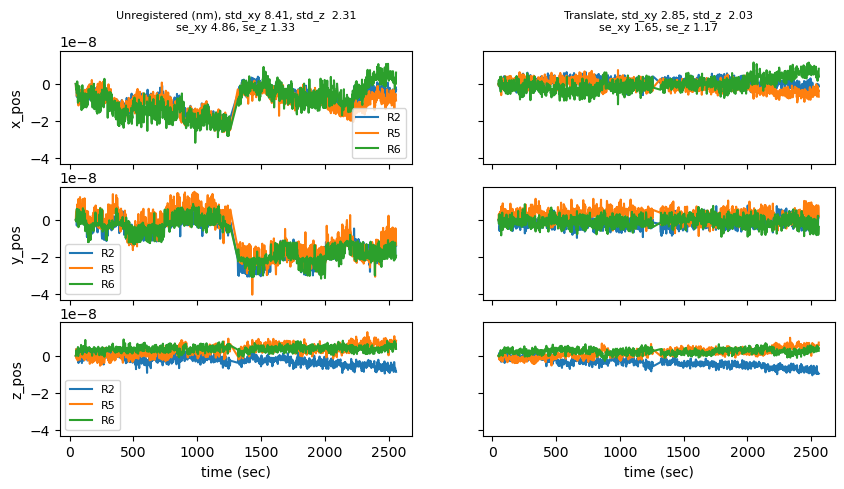

Valid tracks 220601_Syp_P1 32/46302
Localizations in invalid tracks 220601_Syp_P1 2/46433
Valid tracks 220601_ATG9_P2 20/46215
Localizations in invalid tracks 220601_ATG9_P2 7/46308

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220601_Syp_ATG9_ROI04.msr
['R10', 'R2', 'R5', 'R6']
['R10', 'R2', 'R5', 'R6']


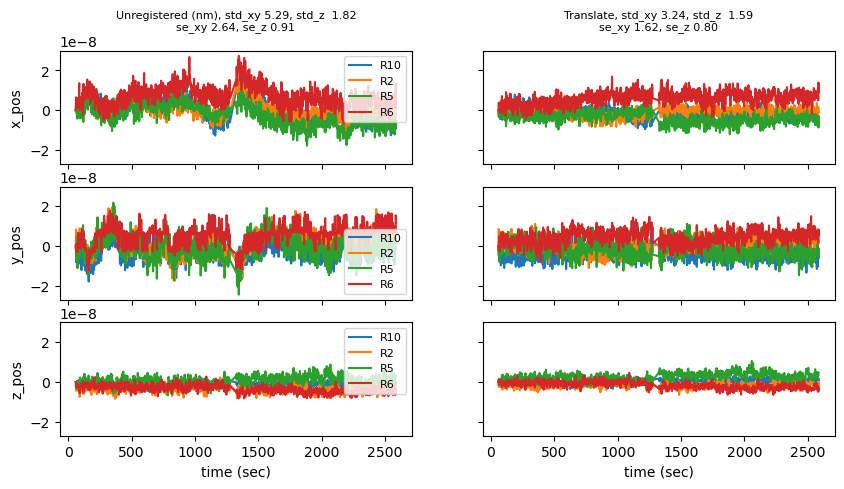

Valid tracks 220601_Syp_P1 85/29952
Localizations in invalid tracks 220601_Syp_P1 8/30313
Valid tracks 220601_ATG9_P2 106/31978
Localizations in invalid tracks 220601_ATG9_P2 8/32633

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220601_Syp_ATG9_ROI05.msr
['R1', 'R3', 'R4', 'R5']
['R1', 'R3', 'R4', 'R5']


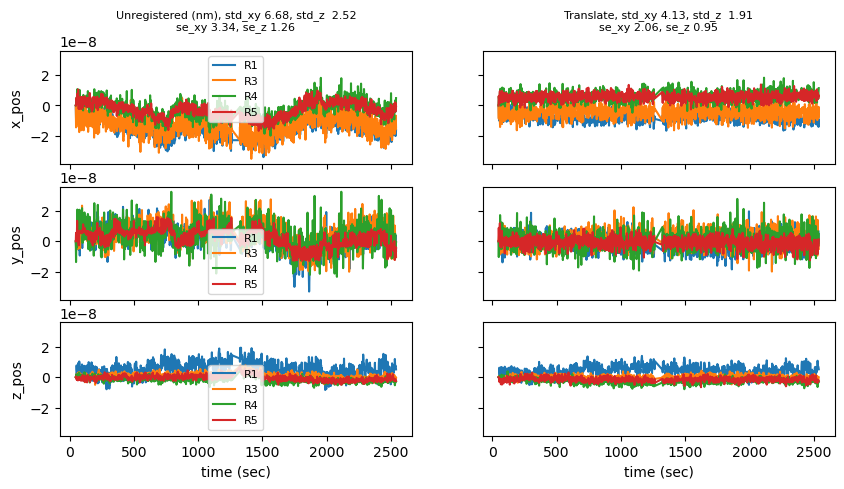

Valid tracks 220601_Syp_P1 322/25197
Localizations in invalid tracks 220601_Syp_P1 48/26502
Valid tracks 220601_ATG9_P2 150/24969
Localizations in invalid tracks 220601_ATG9_P2 31/25664

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220601_Syp_ATG9_ROI06.msr
['R1', 'R3', 'R4', 'R5']
['R1', 'R3', 'R4', 'R5']


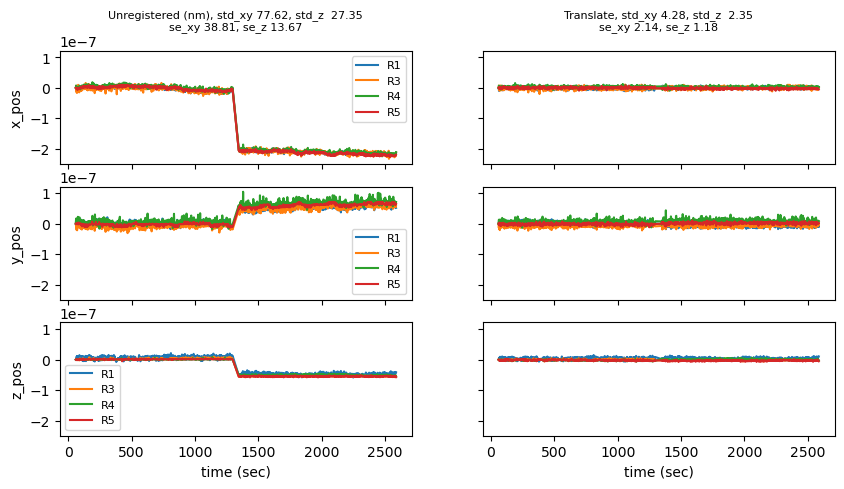

Valid tracks 220601_Syp_P1 260/20820
Localizations in invalid tracks 220601_Syp_P1 48/21902
Valid tracks 220601_ATG9_P2 62/21873
Localizations in invalid tracks 220601_ATG9_P2 8/22107

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220601_Syp_ATG9_ROI07.msr
['R2', 'R3', 'R4']
['R2', 'R3', 'R4']


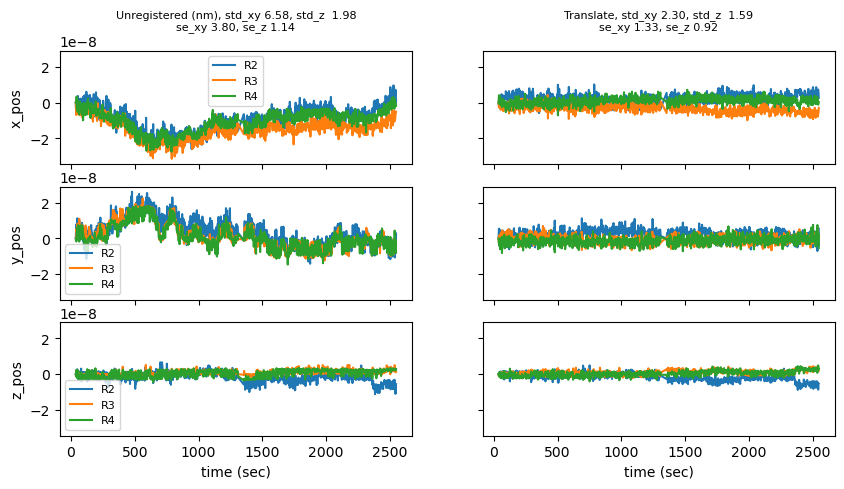

Valid tracks 220601_Syp_P1 228/40386
Localizations in invalid tracks 220601_Syp_P1 51/41287
Valid tracks 220601_ATG9_P2 74/37776
Localizations in invalid tracks 220601_ATG9_P2 21/38103

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220614_Syp_ATG9_ROI01.msr
['R13', 'R20', 'R7']
['R13', 'R20', 'R7']


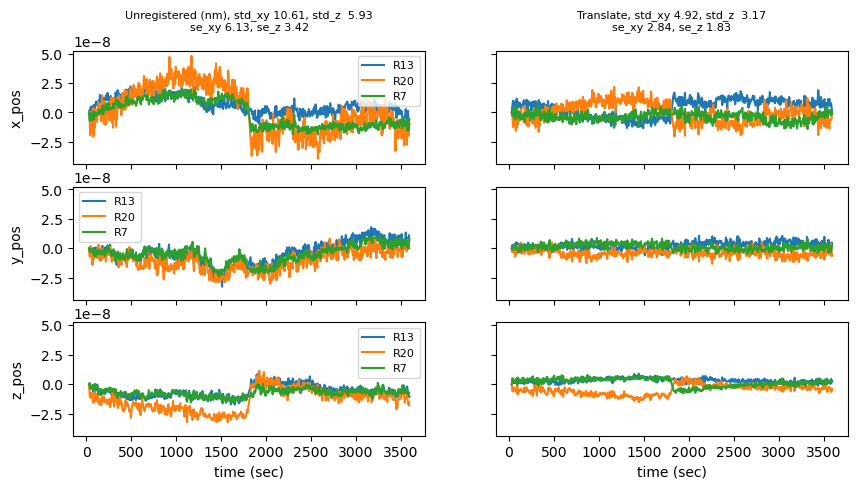

Valid tracks 220614_Syn_P1 2130/48132
Localizations in invalid tracks 220614_Syn_P1 5/59822
Valid tracks 220614_ATG9_P2 1335/53333
Localizations in invalid tracks 220614_ATG9_P2 7/61261

Z:/siva_minflux/data//Multiwash/Syp_ATG9\220825_Syp_ATG9_ROI01.msr
['R13', 'R15', 'R17', 'R3', 'R32']
['R15', 'R17', 'R3', 'R32']


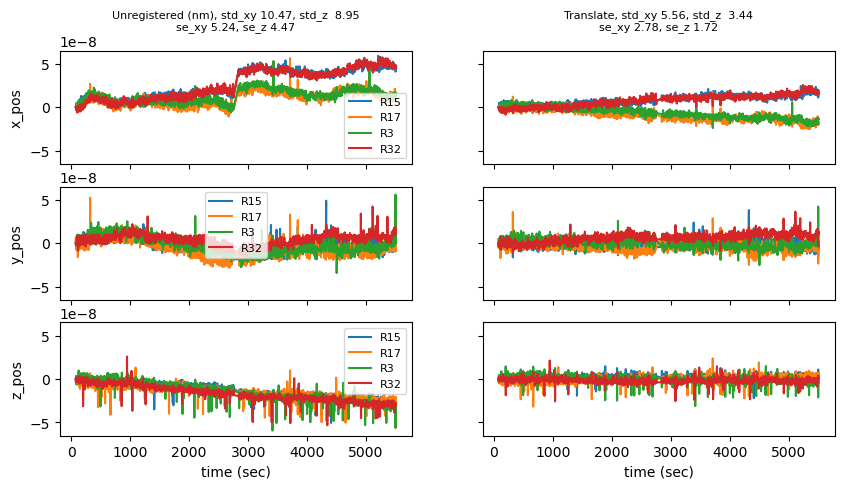

Valid tracks 220825_SYP_P1 831/107493
Localizations in invalid tracks 220825_SYP_P1 14/113239
Valid tracks 220825_ATG9_P2 1020/105159
Localizations in invalid tracks 220825_ATG9_P2 11/111814

Z:/siva_minflux/data//Multiwash/ZnT3_Syp\220309_ZnT3_Syp_ROI01.msr
['R1', 'R3', 'R4']
['R1', 'R3', 'R4']


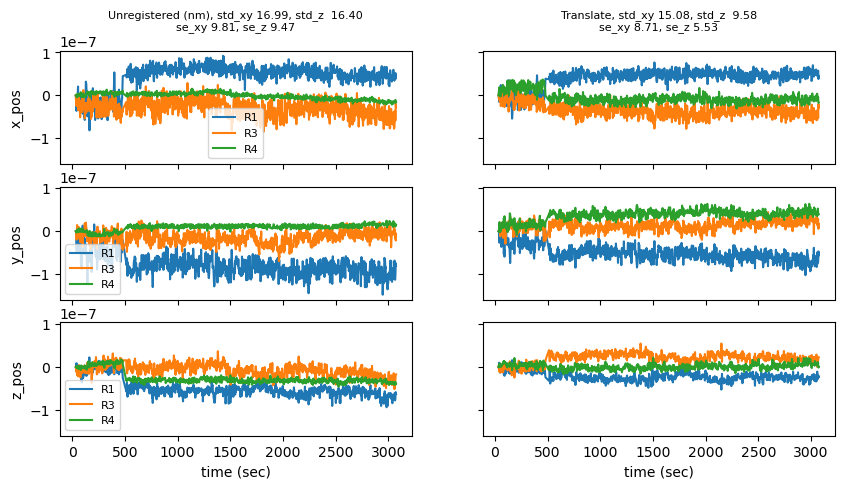

Valid tracks 220309_ZnT3_P1 518/81569
Localizations in invalid tracks 220309_ZnT3_P1 16/84897
Valid tracks 220309_Syp_P2 1168/103172
Localizations in invalid tracks 220309_Syp_P2 24/110589

Z:/siva_minflux/data//Multiwash/ZnT3_Syp\220309_ZnT3_Syp_ROI02.msr
['R10', 'R6', 'R9']
['R10', 'R6', 'R9']


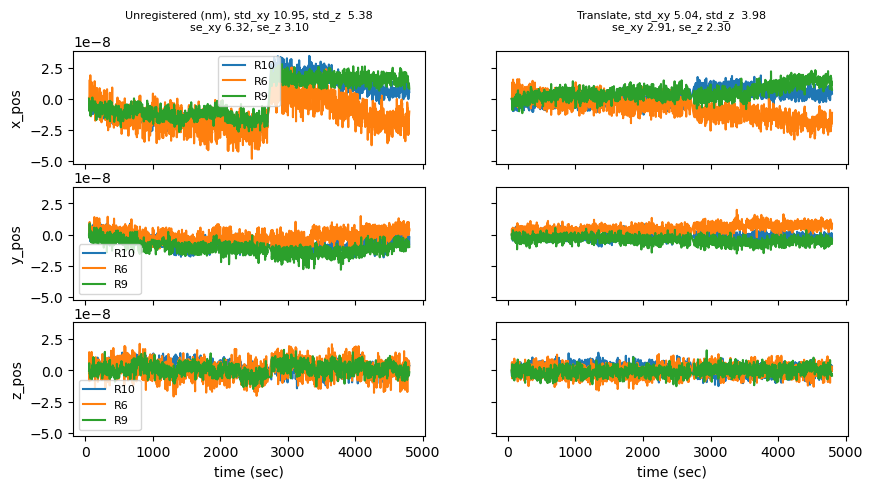

Valid tracks 220309_ZnT3_P1 362/82966
Localizations in invalid tracks 220309_ZnT3_P1 10/85508
Valid tracks 220309_Syp_P2 725/62887
Localizations in invalid tracks 220309_Syp_P2 11/67052

Z:/siva_minflux/data//Multiwash/ZnT3_Syp\220309_ZnT3_Syp_ROI03.msr
['R3', 'R4']
['R3', 'R4']


T:\Antonio_Politi\Code\minflux-analysis\python\mfxdata.py:217: UserWarning: Less than 3 reference beads, rotation registration is not computed
  warnings.warn("Less than 3 reference beads, rotation registration is not computed", category=UserWarning)


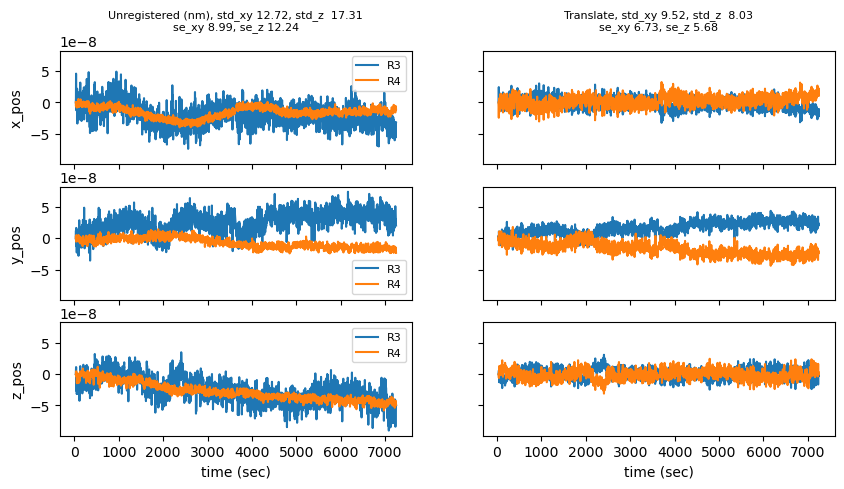

Valid tracks 220309_ZnT3_P1 3410/119776
Localizations in invalid tracks 220309_ZnT3_P1 62/137165
Valid tracks 220309_Syp_P2 3232/122355
Localizations in invalid tracks 220309_Syp_P2 32/138796


In [6]:
# Realign data 
align_data(msr_files=msr_mwash, outdir=outdir_mwash, zarr_dir=zarrdir_mwash, 
           invalid_msr=invalid_mwash, exclude_beads=exclude_beads_mwash, time_diff_ref=time_diff_mwash)
        

Z:/siva_minflux/data//Single wash/Syp\220825_Syp_ROI3.msr
{'220825_Syp_P1': 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis//Single wash/Syp/220825_Syp_ROI3\\220825_Syp_P1'}
['R14', 'R21']


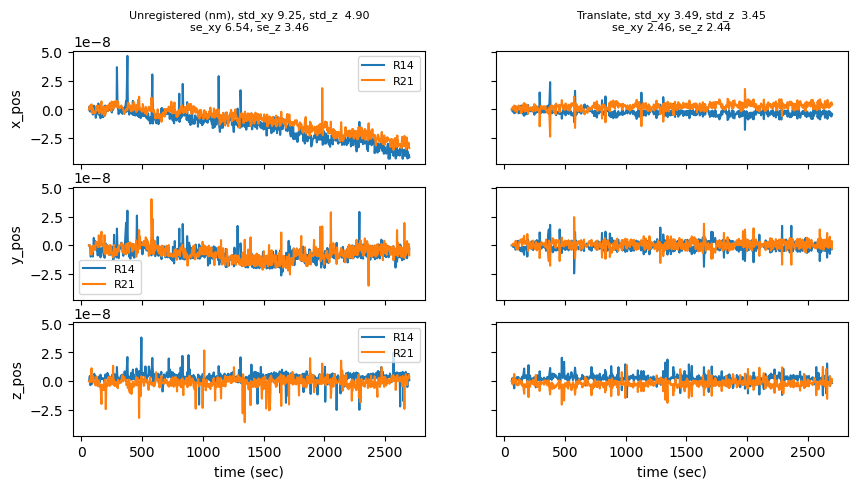

In [7]:
# Preview data single
preview_data(msr_files=msr_swash, outdir=outdir_swash, zarr_dir=zarrdir_swash, 
             wash_key='Syp', idfile=1, time_diff_ref=10)


In [8]:
# Valid msr files, for instance because lacking of common reference. This can be fixed at a later time point 
invalid_swash = {}
exclude_beads_swash = {}
# Achieve 3 or more beads, or leave 2 if not enough time points
time_diff_swash = {'220825_Syp_ROI2.msr': 300, '220825_Syp_ROI3.msr': 1100, 
                   '220825_Syp_ROI4.msr': 1200, '220825_Syp_ROI5.msr': 10, 
                    '220825_Syp_ROI6.msr': 10, '220825_ATG9_ROI3.msr': 400}
# Syp
# 220825_Syp_ROI2.msr: 3 beads, ok
# 220825_Syp_ROI3.msr: 3 beads, ok
# 220825_Syp_ROI4.msr: 3 beads, ok; 1200 sec
# 220825_Syp_ROI5.msr: 5 beads, good
# 220825_Syp_ROI6.msr: 2 beads!, poor. Otherwise only 10 min

# ATG9
# 220825_ATG9_ROI2.msr: 4 beads, good
# 220825_ATG9_ROI3.msr: 3 beads, ok
# 220825_ATG9_ROI4.msr: 3 beads, ok
# 220825_ATG9_ROI5.msr: 2 beads, poor
# 220825_ATG9_ROI6.msr: 3 beads, ok


Z:/siva_minflux/data//Single wash/Syp\220825_Syp_ROI2.msr
['R14', 'R21', 'R22', 'R26']
['R14', 'R21', 'R22', 'R26']


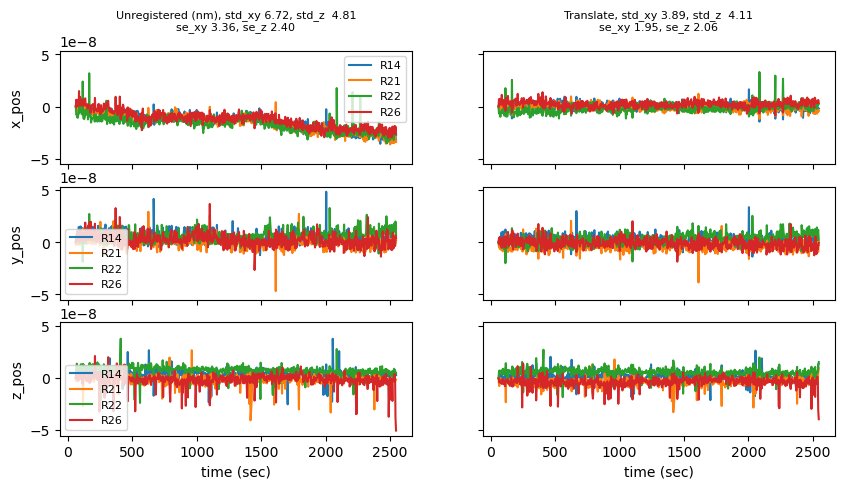

Valid tracks 220825_Syp_P1 1430/97760
Localizations in invalid tracks 220825_Syp_P1 21/105626

Z:/siva_minflux/data//Single wash/Syp\220825_Syp_ROI3.msr
['R0', 'R14', 'R21']
['R0', 'R14', 'R21']


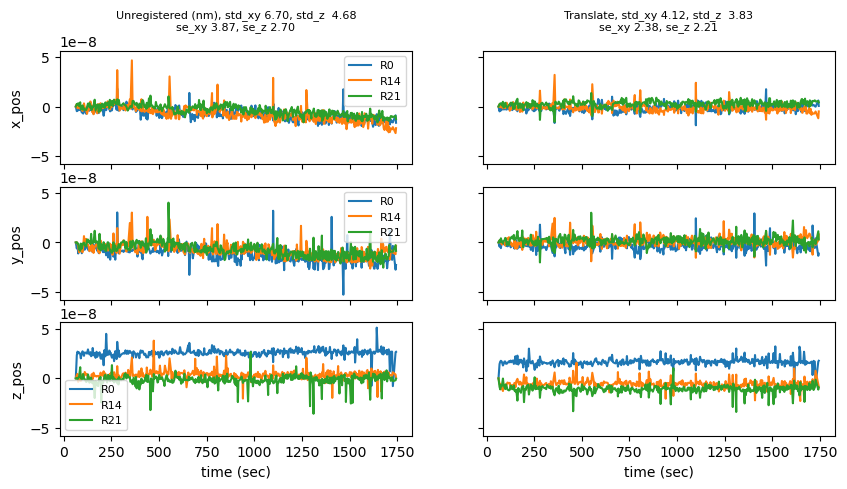

Valid tracks 220825_Syp_P1 1117/104426
Localizations in invalid tracks 220825_Syp_P1 20/110227

Z:/siva_minflux/data//Single wash/Syp\220825_Syp_ROI4.msr
['R0', 'R21', 'R31']
['R0', 'R21', 'R31']


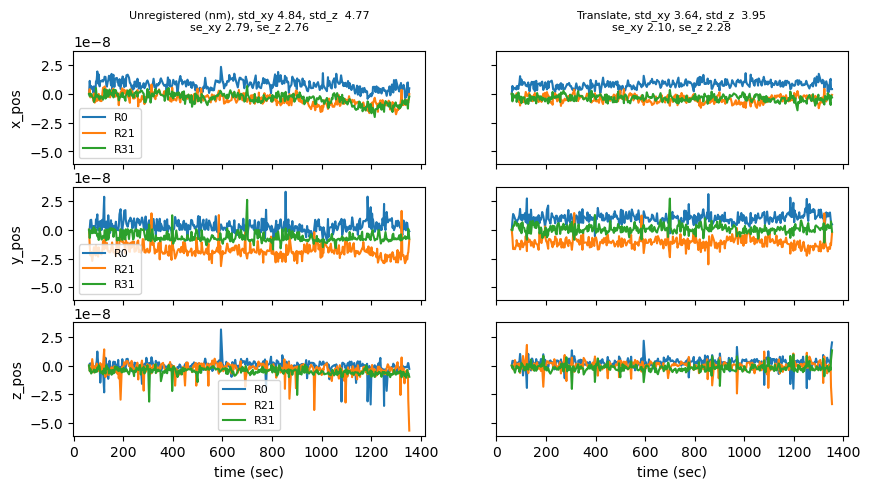

Valid tracks 220825_Syp_P1 1276/101892
Localizations in invalid tracks 220825_Syp_P1 39/107771

Z:/siva_minflux/data//Single wash/Syp\220825_Syp_ROI5.msr
['R0', 'R21', 'R31', 'R4', 'R8']
['R0', 'R21', 'R31', 'R4', 'R8']


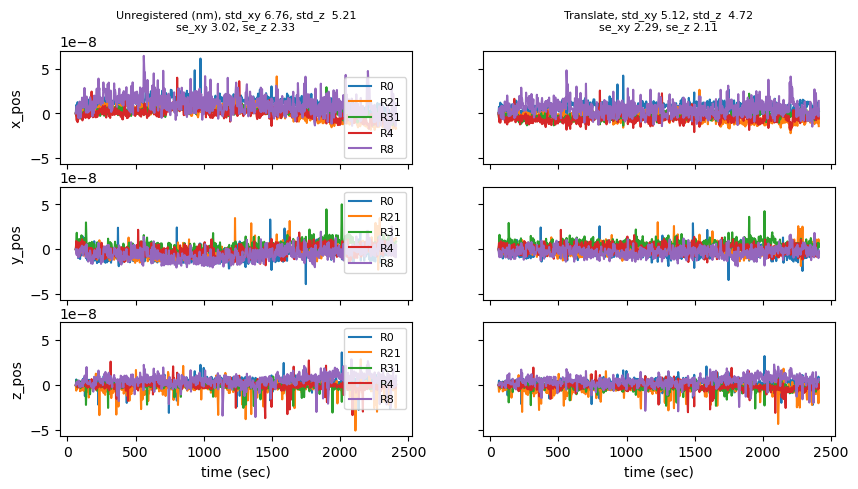

Valid tracks 220825_Syp-P1 791/103756
Localizations in invalid tracks 220825_Syp-P1 9/108202

Z:/siva_minflux/data//Single wash/Syp\220825_Syp_ROI6.msr
['R10', 'R2']
['R10', 'R2']


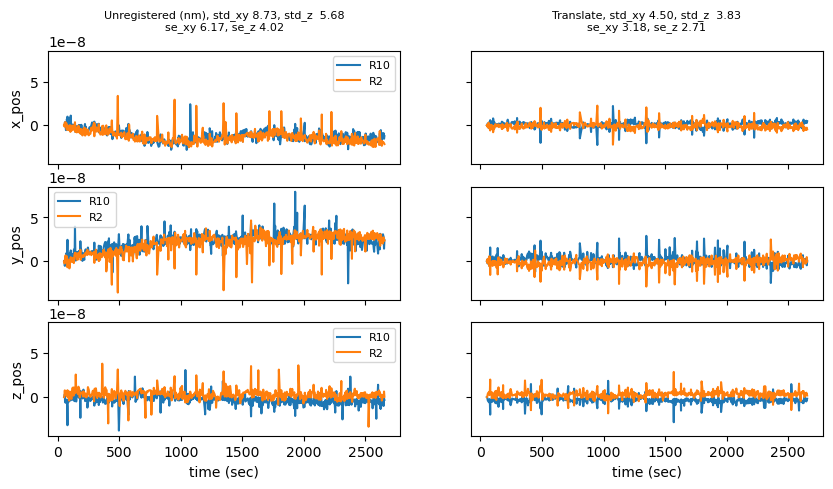

Valid tracks 220825_Syp_P1 2028/96638
Localizations in invalid tracks 220825_Syp_P1 36/108017

Z:/siva_minflux/data//Single wash/ATG9\220825_ATG9_ROI2.msr
['R16', 'R19', 'R2', 'R21']
['R16', 'R19', 'R2', 'R21']


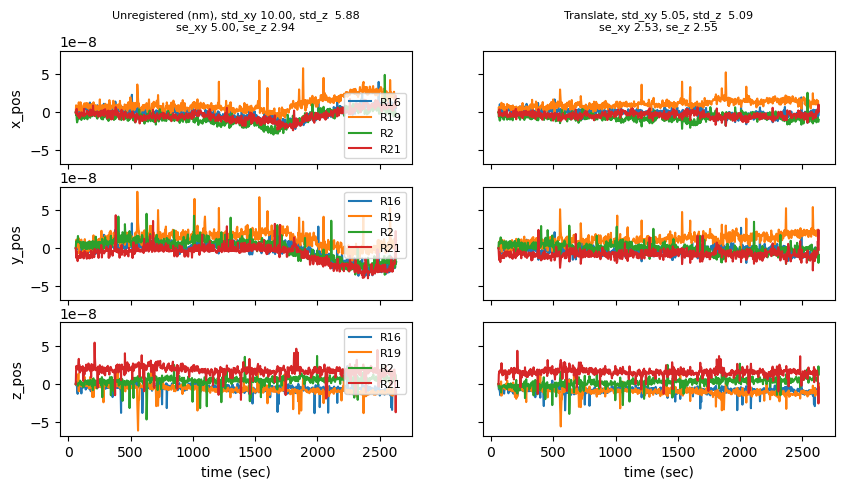

Valid tracks 220825_ATG9_ROI2 591/105419
Localizations in invalid tracks 220825_ATG9_ROI2 4/108662

Z:/siva_minflux/data//Single wash/ATG9\220825_ATG9_ROI3.msr
['R19', 'R2', 'R21']
['R19', 'R2', 'R21']


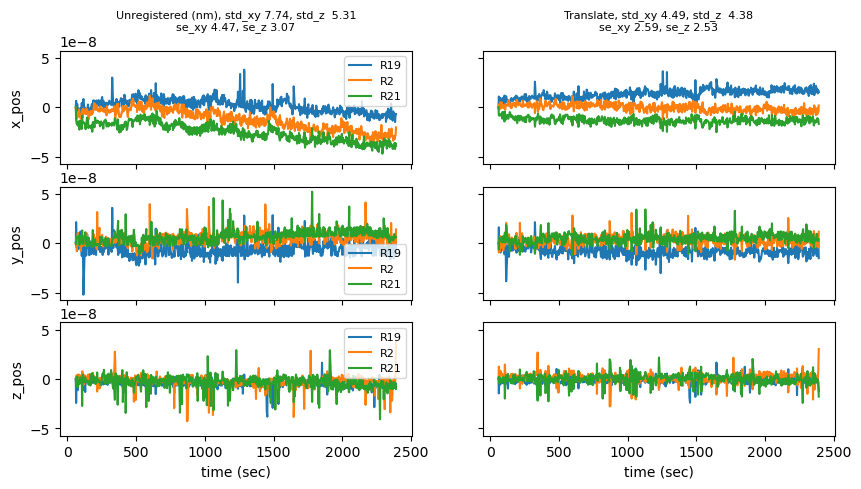

Valid tracks 220825_ATG9_P2 821/106510
Localizations in invalid tracks 220825_ATG9_P2 5/110746

Z:/siva_minflux/data//Single wash/ATG9\220825_ATG9_ROI4.msr
['R18', 'R21', 'R5']
['R18', 'R21', 'R5']


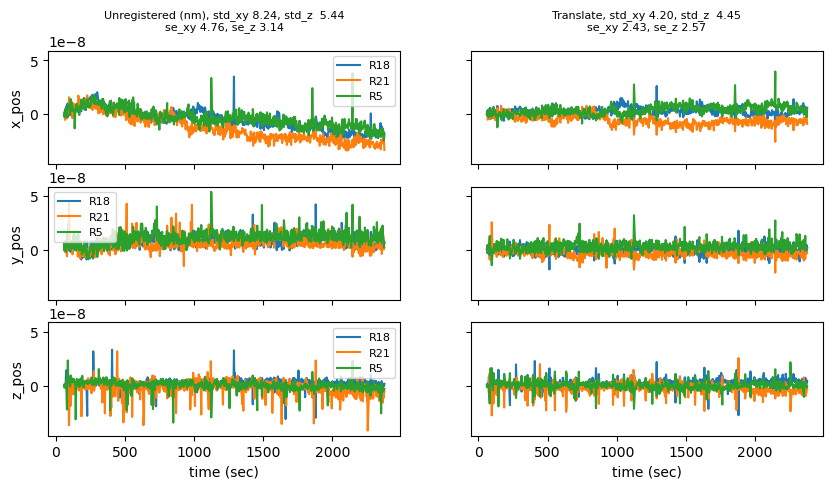

Valid tracks 220825_ATG9_P2 722/103752
Localizations in invalid tracks 220825_ATG9_P2 13/106947

Z:/siva_minflux/data//Single wash/ATG9\220825_ATG9_ROI5.msr
['R18', 'R2']
['R18', 'R2']


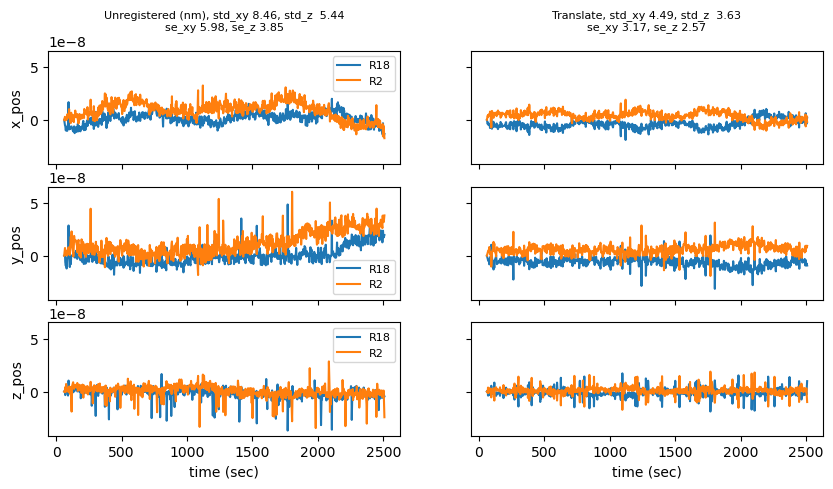

Valid tracks 220825_ATG9_P2 665/107373
Localizations in invalid tracks 220825_ATG9_P2 4/111066

Z:/siva_minflux/data//Single wash/ATG9\220825_ATG9_ROI6.msr
['R1', 'R15', 'R19']
['R1', 'R15', 'R19']


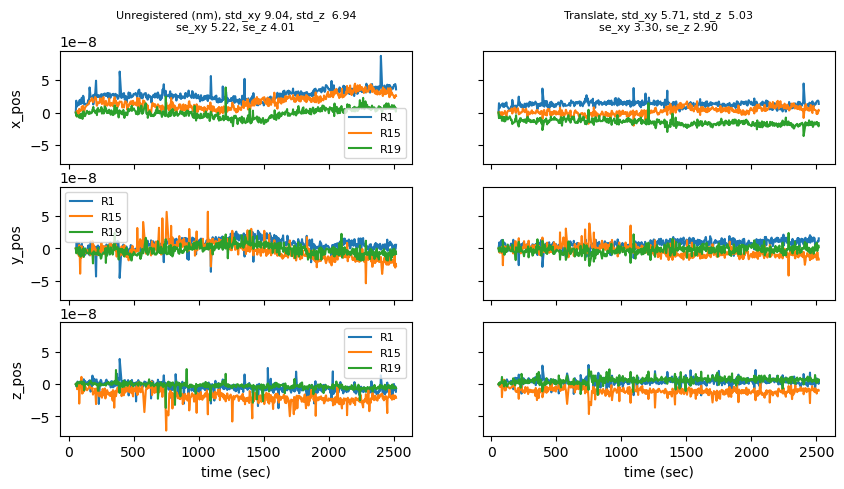

Valid tracks 220825_ATG9_P2 1286/101673
Localizations in invalid tracks 220825_ATG9_P2 29/109703


In [9]:
align_data(msr_files=msr_swash, outdir=outdir_swash, zarr_dir=zarrdir_swash, 
           invalid_msr=invalid_swash, exclude_beads=exclude_beads_swash, time_diff_ref=time_diff_swash)
        

Z:/siva_minflux/data//Multiwash/VGLUT1_VGLUT1\220804_VGLUT1_ROI01_First.msr
{'220804_VGLUT1_P1': 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis//Multiwash/VGLUT1_VGLUT1/220804_VGLUT1_ROI01_First\\220804_VGLUT1_P1'}
['R17', 'R30']


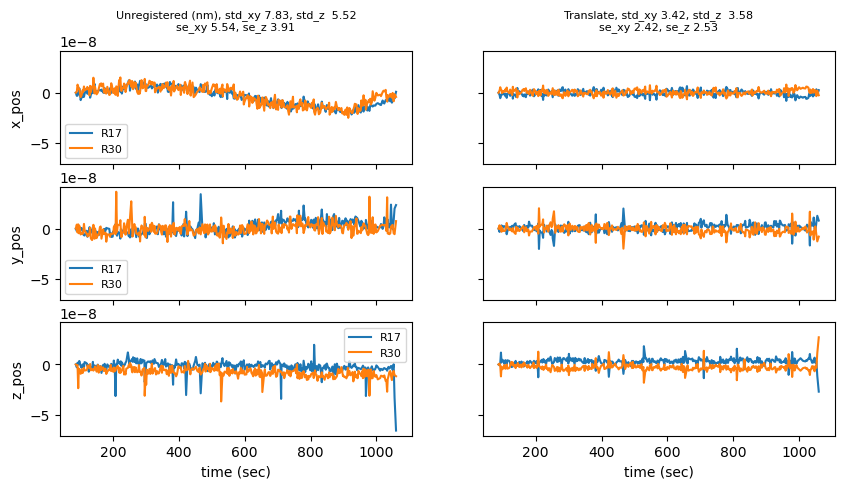

In [10]:
# Preview data cwash
preview_data(msr_files=msr_cwash, outdir=outdir_cwash, zarr_dir=zarrdir_cwash,  wash_key='VGLUT1_VGLUT1',
             idfile=0, time_diff_ref=800)

In [11]:
# Valid msr files, for instance because lacking of common reference. This can be fixed at a later time point 
invalid_cwash = {}
exclude_beads_cwash = {}
# Achieve 3 or more beads, or leave 2 if not enough time points
time_diff_cwash = {'220804_VGLUT1_ROI01_First.msr': 800, '220804_VGLUT1_ROI01_Second.msr': 800}
# VGLUT1
# 220804_VGLUT1_ROI01_First.msr: 2 beads only. Only 1 that cross-matches between washes = 'R17'
# 220804_VGLUT1_ROI01_First.msr: 2 beads only. Only 1 that cross-matches between washes = 'R17'
# 2208011_VGLUT1_ROI01_First.msr: 5 beads. May be  [['R1', 'R6'], ['R22', 'R15'], ['R3', 'R7'], ['R8', 'R9']]
# 2208011_VGLUT1_ROI01_Second.msr: 5 beads match with 150 nm distance!



In [12]:
# Hack beacause of not merged files
indir_cwash = INDIR + '/Multiwash/VGLUT1_VGLUT1/'
outdir_cwash = OUTDIR_REM +  '/Multiwash/VGLUT1_VGLUT1/'
zarrdir_cwash =  OUTDIR_LOC +  '/Multiwash/VGLUT1_VGLUT1/'

msr_cwash = ['Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220804_VGLUT1_ROI01_First.msr', 
             'Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220811_VGLUT1_ROI01_First.msr']

zarr_dir = {'220804_VGLUT1_ROI01_First.msr': {'220804_VGLUT1_P1': zarrdir_cwash + '/220804_VGLUT1_ROI01/220804_VGLUT1_P1',
             '220804_VGLUT1_P2': zarrdir_cwash + '/220804_VGLUT1_ROI01/220804_VGLUT1_P2'},
            '220811_VGLUT1_ROI01_First.msr': {'220811_VGLUT1_P1': zarrdir_cwash + '/220811_VGLUT1_ROI01/220811_VGLUT1_P1',
             '220811_VGLUT1_P2': zarrdir_cwash+ '/220811_VGLUT1_ROI01/220811_VGLUT1_P2'} }



Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220804_VGLUT1_ROI01_First.msr
['R17']
['R17']


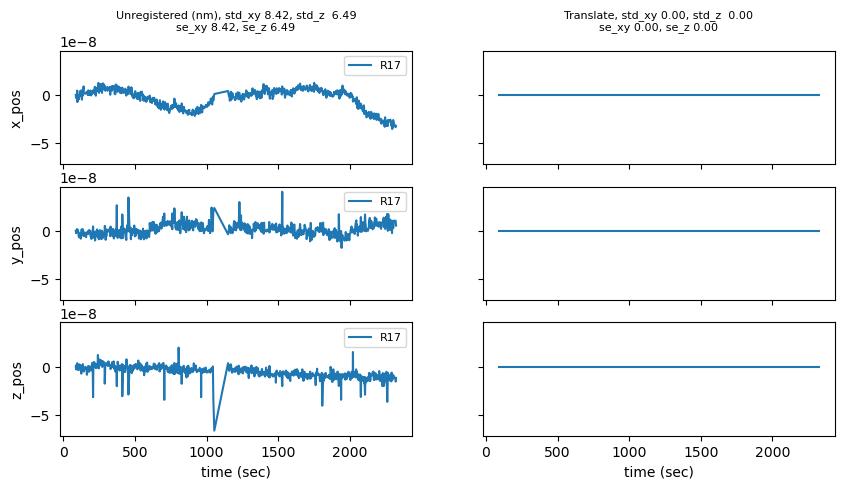

Valid tracks 220804_VGLUT1_P1 555/54066
Localizations in invalid tracks 220804_VGLUT1_P1 2/56596
Valid tracks 220804_VGLUT1_P2 464/62245
Localizations in invalid tracks 220804_VGLUT1_P2 1/64386

Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220811_VGLUT1_ROI01_First.msr
['R1', 'R22', 'R3', 'R8']
['R1', 'R22', 'R3', 'R8']


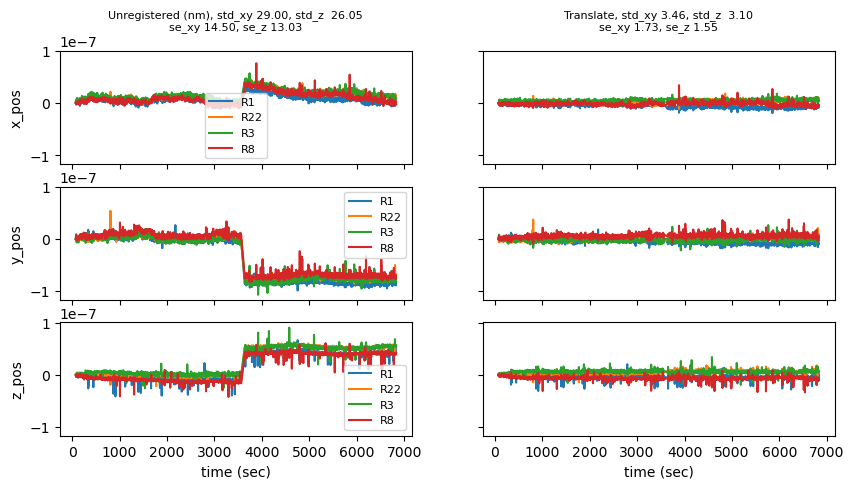

Valid tracks 220811_VGLUT1_P1 2800/100724
Localizations in invalid tracks 220811_VGLUT1_P1 23/115104
Valid tracks 220811_VGLUT1_P2 1989/95253
Localizations in invalid tracks 220811_VGLUT1_P2 12/104441


In [13]:
for file_path in msr_cwash:
    file_name = os.path.basename(file_path)
    if file_name in invalid_cwash:
        continue
    mfx = MfxData(file_path, outdir_main=outdir_cwash, 
                  zarr_dir_main=zarrdir_cwash)
    if file_name in time_diff_cwash:
        mfx.MAX_TDIFF_REF = time_diff_cwash[file_name]
    else:
        mfx.MAX_TDIFF_REF = 10
    mfx.zarrdir = zarr_dir[file_name]
    mfx.zarr_import()
    mfx.set_valid_ref()
    print('\n'+ mfx.msrfile_path)
    print(mfx.valid_ref_beads)
    if file_name in exclude_beads_cwash:
        mfx.valid_ref_beads = [x for x in mfx.valid_ref_beads if x not in exclude_beads_cwash[file_name]]
    print(mfx.valid_ref_beads)
    regis = mfx.get_ref_transform()
    mfx.show_ref_transform(translate=regis[mfx.TRANS], rotate=None, save=True, show=True)
    out_data_dict = mfx.align_to_ref()
    mfx.export_numpy(out_data_dict)
    mfx.export_ref_mat() 